In [2]:
import pandas as pd

## Exercise
1- Look at sensor data that tracks atmospheric $CO_2$ from continuous air samples at Mauna Loa Observatory in Hawaii. This data includes $CO_2$ samples from March 1958 to December 1980.
- Determine the presence of main trend and seasonality in the data
- Determine if the data are stationary
- Split the data in train (90%) and test (10%)
- Find a set of SARIMAX coordinate models by looking at the ACF and PACF plots.
- Perform a grid search on the model candidates.
- Select the best models, based on performance metrics, model complexity, and normality of the residuals.
- Compare the best model you found with the one from autoarima.

In [3]:
co2 = pd.read_csv('https://zenodo.org/records/10951538/files/arima_co2.csv?download=1',
                  header = 0,
                  names = ['idx', 'co2'],
                  skipfooter = 2,
                  engine='python')

# convert the column idx into a datetime object and set it as the index
co2['idx'] = pd.to_datetime(co2['idx'])
co2.set_index('idx', inplace=True)

# Rmove the name "idx" from the index column
co2.index.name = None
co2

,co2
1965-01-01,319.32
1965-02-01,320.36
1965-03-01,320.82
1965-04-01,322.06
1965-05-01,322.17
...,...
1980-08-01,337.19
1980-09-01,335.49
1980-10-01,336.63
1980-11-01,337.74


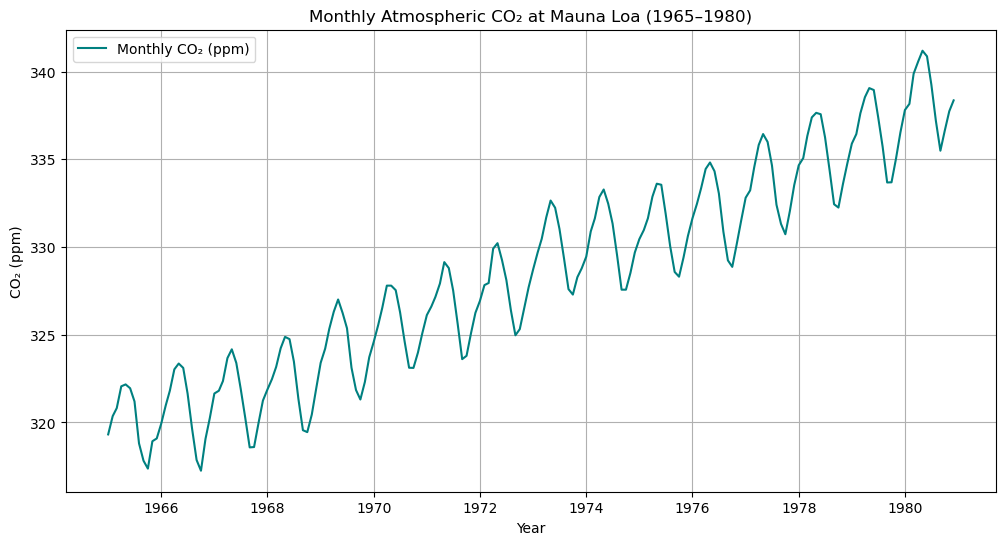

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(co2, label='Monthly CO₂ (ppm)', color='teal')
plt.title('Monthly Atmospheric CO₂ at Mauna Loa (1965–1980)')
plt.ylabel('CO₂ (ppm)')
plt.xlabel('Year')
plt.grid(True)
plt.legend()
plt.show()


C:\Users\franc\AppData\Local\Temp\ipykernel_19036\2448037295.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


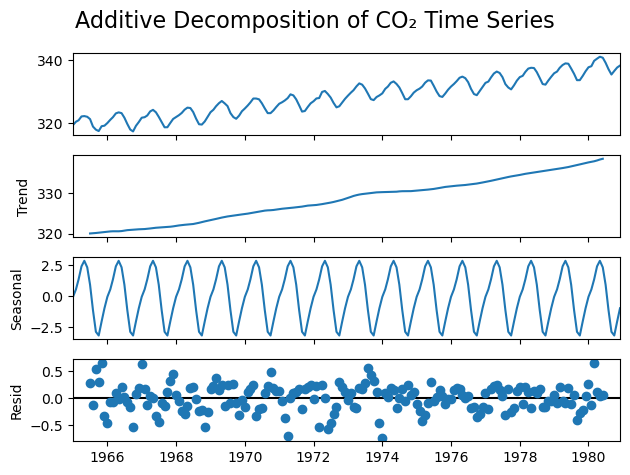

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

dcmp = seasonal_decompose(co2, model='additive', period=12)

dcmp.plot()
plt.suptitle('Additive Decomposition of CO₂ Time Series', fontsize=16)
plt.tight_layout()
plt.show()


In [6]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss


stat, p_value, lags, crit = kpss(co2['co2'], regression='c', nlags="auto")

print(f'KPSS Statistic: {stat}')
print(f'p-value: {p_value}')
print(f'Lags used: {lags}')
print(f'Critical values: {crit}')


KPSS Statistic: 1.9852615080853047
p-value: 0.01
Lags used: 9
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\franc\AppData\Local\Temp\ipykernel_19036\1358937827.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p_value, lags, crit = kpss(co2['co2'], regression='c', nlags="auto")


In [7]:
split_index = int(len(co2) * 0.9)
train = co2.iloc[:split_index]
test = co2.iloc[split_index:]

print(train.shape, test.shape)


(172, 1) (20, 1)


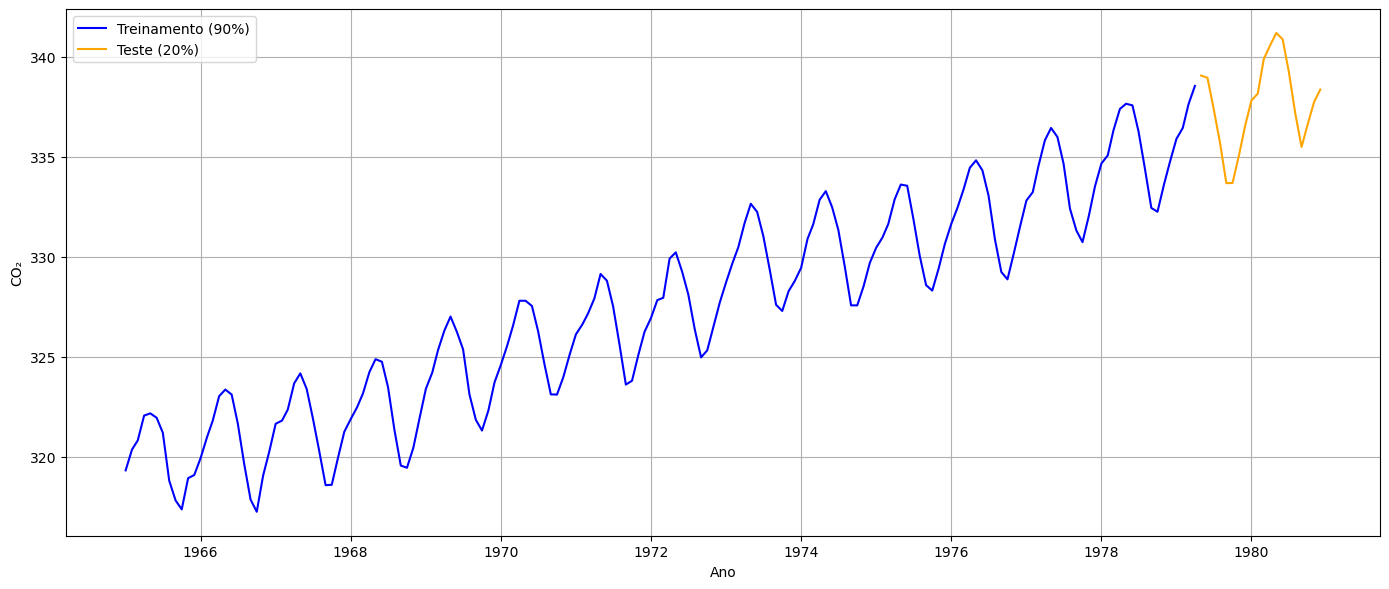

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(train, label='Treinamento (90%)', color='blue')
plt.plot(test, label='Teste (20%)', color='orange')
plt.xlabel('Ano')
plt.ylabel('CO₂')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


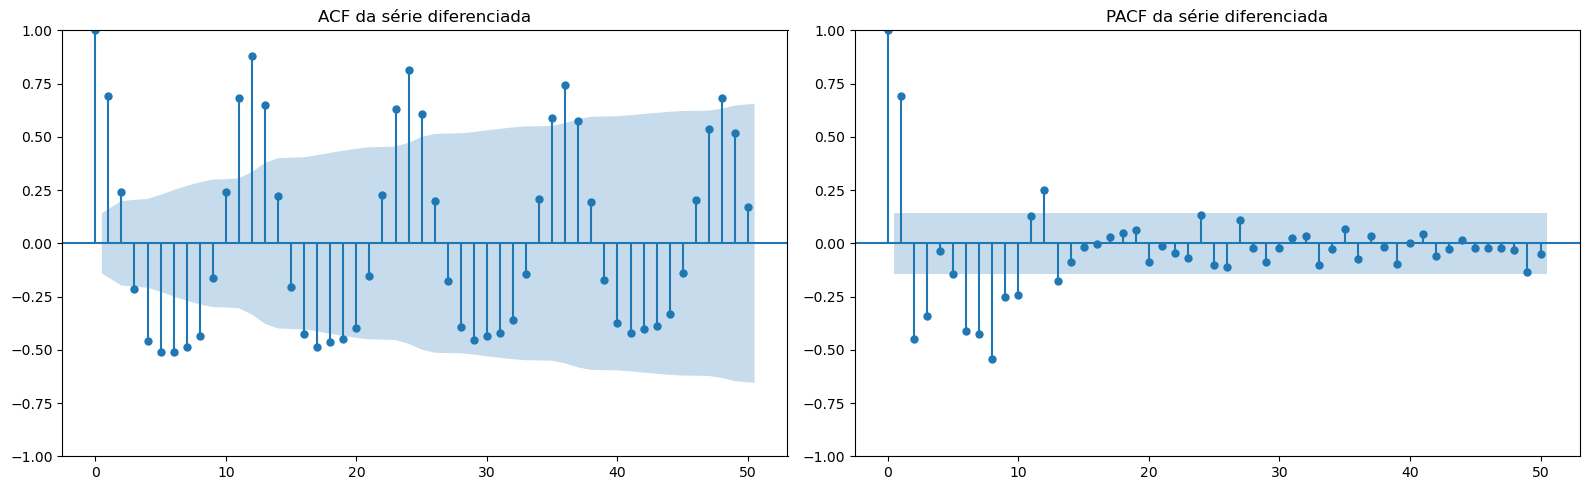

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

co2_diff = co2.diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(co2_diff, ax=axes[0], lags=50)
axes[0].set_title('ACF da série diferenciada')

plot_pacf(co2_diff, ax=axes[1], lags=50, method='ywm') 
axes[1].set_title('PACF da série diferenciada')

plt.tight_layout()
plt.show()


In [ ]:
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

sarimax_candidates = [
    (1, 1, 1, 1, 1, 1, 12),
    (2, 1, 1, 1, 1, 1, 12),
    (1, 1, 2, 1, 1, 1, 12),
    (1, 1, 1, 2, 1, 1, 12),
    (2, 1, 2, 1, 1, 1, 12),
    (1, 1, 1, 1, 1, 0, 12),
    (1, 1, 1, 0, 1, 1, 12),
]

results = []

for order in sarimax_candidates:
    p, d, q, P, D, Q, s = order
    try:
        model = SARIMAX(train['co2'],
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        result = model.fit(disp=False)
        results.append({
            'order': (p, d, q),
            'seasonal_order': (P, D, Q, s),
            'aic': result.aic,
            'bic': result.bic,
            'model': result
        })
        print(f'Model {(p,d,q)}x{(P,D,Q,s)} - AIC: {result.aic:.2f}, BIC: {result.bic:.2f}')
    except Exception as e:
        print(f'Model {(p,d,q)}x{(P,D,Q,s)} failed: {e}')


Model (1, 1, 1)x(1, 1, 1, 12) - AIC: 66.72, BIC: 81.60
Model (2, 1, 1)x(1, 1, 1, 12) - AIC: 69.32, BIC: 87.18
Model (1, 1, 2)x(1, 1, 1, 12) - AIC: 68.20, BIC: 86.02
Model (1, 1, 1)x(2, 1, 1, 12) - AIC: 65.56, BIC: 82.94
Model (2, 1, 2)x(1, 1, 1, 12) - AIC: 69.21, BIC: 90.00
Model (1, 1, 1)x(1, 1, 0, 12) - AIC: 93.21, BIC: 105.15
Model (1, 1, 1)x(0, 1, 1, 12) - AIC: 67.63, BIC: 79.53


In [13]:
best_model_info = min(results, key=lambda x: x['aic'])

print("\nMelhor modelo encontrado:")
print(f"Order: {best_model_info['order']}")
print(f"Seasonal Order: {best_model_info['seasonal_order']}")
print(f"AIC: {best_model_info['aic']:.2f}")
print(f"BIC: {best_model_info['bic']:.2f}")



Melhor modelo encontrado:
Order: (1, 1, 1)
Seasonal Order: (2, 1, 1, 12)
AIC: 65.56
BIC: 82.94


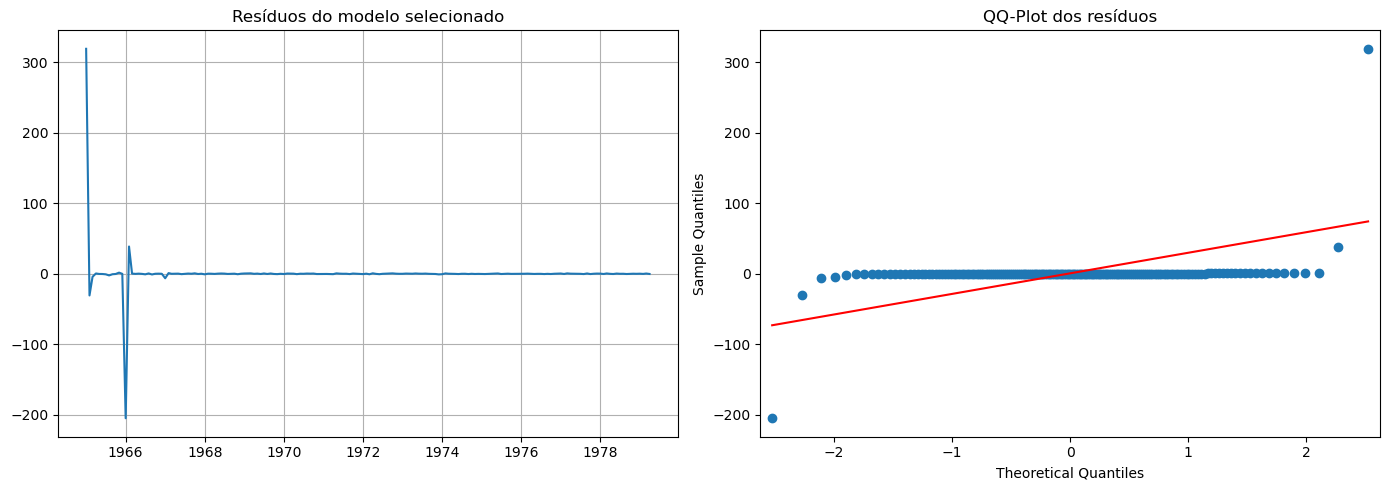

Shapiro-Wilk test p-value: 0.0000


In [14]:
residuals = best_model_info['model'].resid

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title("Resíduos do modelo selecionado")
plt.grid(True)

plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title("QQ-Plot dos resíduos")

plt.tight_layout()
plt.show()

from scipy.stats import shapiro
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {shapiro_test.pvalue:.4f}")


In [16]:
!pip install pmdarima


  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ac/f8/6c9364602b13f0dba129b53acd1344859690911a4d5021560d9fd6aa087f/pmdarima-2.0.4-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/53/6e/3ea341450bc40f3c0c3da9ae05c22eeb59930531accba78a4b3eebaf342c/cython-3.1.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   - -------------------------------------- 30.7/614.7 kB 1.3 MB/s eta 0:00:01
   --------- ------------------------------ 143.4/614.7 kB 2.1 MB/s eta 0:00:01
   ----------------------- ---------------- 368.6/614.7 kB 3.8 MB/s eta 0:00:01
   ----------------------------------- ---- 553.0/614.7 kB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 614.7/614.7 kB 3.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ------ ---------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=3.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=170.140, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=116.893, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=167.257, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=112.261, Time=0.80 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.00 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.43 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=116.848, Time=0.47 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=114.093, Time=0.99 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=111.836, Time=1.27 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=116.214, Time=0.76 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=3.57 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.88 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=111.627, Time=

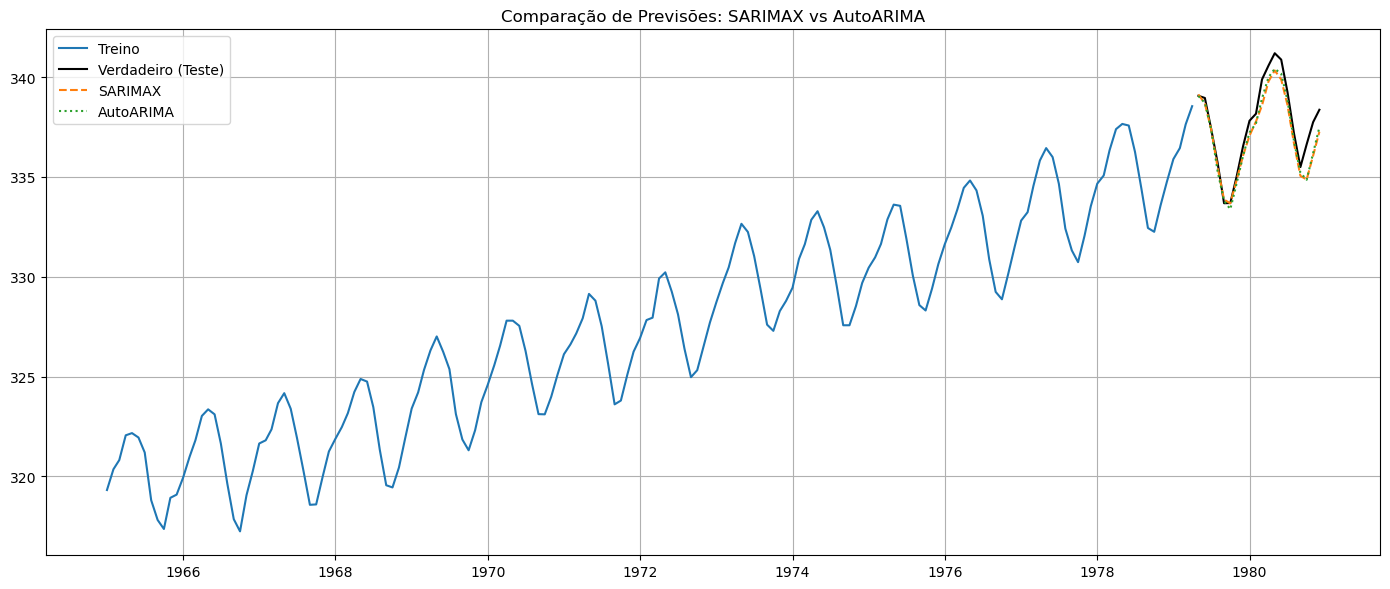

In [ ]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import numpy as np

auto_model = auto_arima(train['co2'],
                        seasonal=True,
                        m=12,
                        d=1, 
                        D=1,
                        trace=True,
                        suppress_warnings=True,
                        stepwise=True,
                        error_action="ignore")

print(f'\nAutoARIMA Model: {auto_model.summary()}')

n_test = len(test)
auto_forecast = auto_model.predict(n_periods=n_test)
sarimax_forecast = best_model_info['model'].forecast(n_test)

rmse_auto = np.sqrt(mean_squared_error(test['co2'], auto_forecast))
rmse_sarimax = np.sqrt(mean_squared_error(test['co2'], sarimax_forecast))

print(f'\nRMSE - AutoARIMA: {rmse_auto:.4f}')
print(f'RMSE - SARIMAX selecionado: {rmse_sarimax:.4f}')

plt.figure(figsize=(14, 6))
plt.plot(train.index, train['co2'], label='Treino')
plt.plot(test.index, test['co2'], label='Verdadeiro (Teste)', color='black')
plt.plot(test.index, sarimax_forecast, label='SARIMAX', linestyle='--')
plt.plot(test.index, auto_forecast, label='AutoARIMA', linestyle=':')
plt.legend()
plt.title('Comparação de Previsões: SARIMAX vs AutoARIMA')
plt.grid(True)
plt.tight_layout()
plt.show()
